In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==3.0.2
!pip install kobert-transformers==0.4.1
!pip install sentencepiece
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/KoBERT_Wellness/')
sys.path.append('drive/MyDrive/Colab Notebooks/KoBERT_Wellness/model')

In [ ]:
import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import dataloader
from tqdm import tqdm
from transformers import AdamW
from kobert_transformers import get_tokenizer

from model.classification import KoBERTClassfication
from model.dataloader import WellnessClassificationDataset

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

In [ ]:
def train(device, epoch, model, optimizer, train_loader, save_step, save_path, train_step_idx=0):
    losses = []
    train_start_idx = train_step_idx + 1 if train_step_idx != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total=total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step_idx)
        
        for i, data in enumerate(train_loader, train_start_idx):
            optimizer.zero_grad()
            
            outputs = model(**data)
            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Last Loss: {loss.item():.3f} (Mean Loss: {np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  
                    'model_state_dict': model.state_dict(),  
                    'optimizer_state_dict': optimizer.state_dict(),  
                    'loss': loss.item(),  
                    'train_step_idx': i,
                    'total_train_step': len(train_loader)  
                }, save_path)

    return np.mean(losses)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
data_path = "drive/MyDrive/Colab Notebooks/KoBERT_Wellness/dataset/wellness_train.txt"
save_path = "drive/My Drive/Colab Notebooks/KoBERT_Wellness/checkpoint/kobert-wellnesee-classification.pth"

n_epoch = 50         
batch_size = 8      
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_step = 100 
learning_rate = 5e-6

dataset = WellnessClassificationDataset(file_path=data_path, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = KoBERTClassfication()
model.to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(parameters, lr=learning_rate)

epoch_step, loss_step, train_step = 0, 0, 0
if os.path.isfile(save_path):
    checkpoint = torch.load(save_path, map_location=device)
    epoch_step = checkpoint['epoch']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_path}, epoch={epoch_step}")  

losses = []
offset = epoch_step
for step in range(n_epoch):
    epoch = step + offset
    loss = train(device, epoch, model, optimizer, train_loader, save_step, save_path, train_step)
    losses.append(loss)

data = {"loss": losses}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
     

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

Train(41):   4%|▍         | 24/596 [00:22<08:49,  1.08it/s, Last Loss: 0.570 (Mean Loss: 0.580)]


KeyboardInterrupt: ignored

,loss
0,5.609061
1,5.504952
2,5.461427
3,5.371879
4,5.210058
5,5.004590
6,4.780394
7,4.571801
8,4.362738
9,4.192443


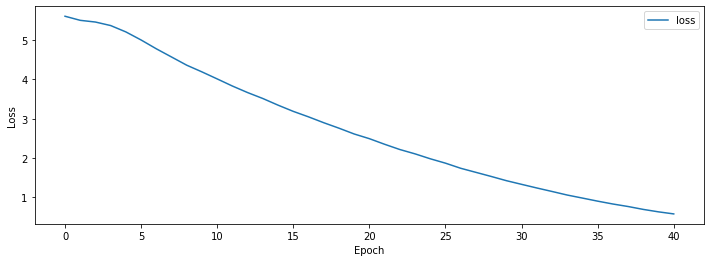

In [ ]:
data = {"loss": losses}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()